In [15]:
import torch
import cv2
from torchvision import transforms
from utils.loss_function import SaliencyLoss
from utils.loss_function import *
from utils.data_process import preprocess_img, postprocess_img, load_input_image
import numpy as np
import matplotlib.pyplot as plt

print("All imports successful")

All imports successful


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from TranSalNet_Res import TranSalNet
model = TranSalNet()
model.load_state_dict(torch.load(r'pretrained_models/TranSalNet_Res.pth', map_location=torch.device('cpu')))

model = model.to(device) 
model.eval()

print("Model imported successfully")

Model imported successfully


In [ ]:
#TARGET CIRCLES
target = torch.zeros(1, 1, 288, 384)

cx1, cy1 = 140, 200
cx2, cy2 = 60, 100
cx3, cy3 = 220, 150

max_dist1, max_dist2, max_dist3 = 80, 60, 50  # set max distances for both circles

xx, yy = torch.meshgrid(torch.linspace(0, target.shape[2] - 1, target.shape[2]), torch.linspace(0, target.shape[3] - 1, target.shape[3]))
distances1 = torch.sqrt((xx - cx1) ** 2 + (yy - cy1) ** 2)
distances2 = torch.sqrt((xx - cx2) ** 2 + (yy - cy2) ** 2)
distances3 = torch.sqrt((xx - cx3) ** 2 + (yy - cy3) ** 2)

values = torch.clamp(1 - distances1 / max_dist1, 0) + torch.clamp(1 - distances2 / max_dist2, 0) + torch.clamp(1 - distances3 / max_dist3, 0)  # add the two circle values together

target[0, 0, :, :] = values
print(target.shape)

toPIL = transforms.ToPILImage()
pic = toPIL(target.squeeze())
display(pic)


In [ ]:
#TARGET CORNER
target = torch.ones(1, 1, 288, 384)

# Set the top right of the tensor to white
target[:, :, :target.shape[2]//2, target.shape[3]//3:] = 1.0

toPIL = transforms.ToPILImage()
pic = toPIL(target.squeeze())
display(pic)

torch.Size([1, 1, 288, 384])


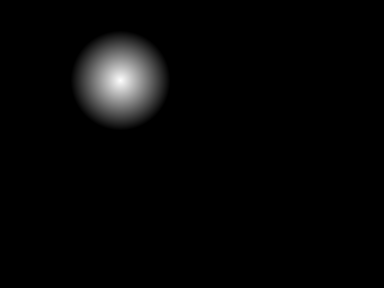

In [48]:
#TARGET CIRCLES
target = torch.zeros(1, 1, 288, 384)

cx1, cy1 = 80, 120

max_dist1 = 50  # set max distances for both circles

xx, yy = torch.meshgrid(torch.linspace(0, target.shape[2] - 1, target.shape[2]), torch.linspace(0, target.shape[3] - 1, target.shape[3]))
distances1 = torch.sqrt((xx - cx1) ** 2 + (yy - cy1) ** 2)

values = torch.clamp(1 - distances1 / max_dist1, 0)

target[0, 0, :, :] = values
print(target.shape)

toPIL = transforms.ToPILImage()
pic = toPIL(target.squeeze())
display(pic)

(288, 384, 3)


(-0.5, 383.5, 287.5, -0.5)

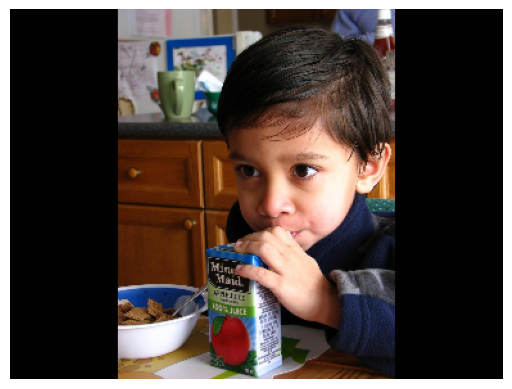

In [47]:
test_img = r'./example/BenchmarkIMAGES/i33.jpg'

#padding and resizing input image into 384x288
original_image = preprocess_img(test_img)
#normalising values
original_image = np.array(original_image)/255.
original_image = np.expand_dims(np.transpose(original_image,(2,0,1)),axis=0)
original_image = torch.from_numpy(original_image)
original_image = original_image.type(torch.FloatTensor).to(device)

original_img_np = cv2.cvtColor(original_image.squeeze().detach().permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)
plt.imshow(original_img_np)
plt.axis("off")

In [ ]:
def patch_attack(patch, target_saliency,loss_target, lr):
    loss_fn=SaliencyLoss()
    loss, iterations =0, 0
    while loss_target > loss:

        print('------------------------------------------')
        
        patch = patch.clone().detach().requires_grad_(True)
        patch.retain_grad()

        out = model(patch)
        
        loss = loss_fn(out,target_saliency,loss_type='cc')
        # loss = loss_fn(out,target,loss_type='cc')
        loss.backward()
        # print(torch.max(patch.grad)*lr)
        patch = patch + (patch.grad * lr)
        
        print(loss)
        print(lr)



        iterations = iterations + 1
        
    return patch, iterations
        
        
    
final_patch, iterations = patch_attack(original_image,target,loss_target = 0.7, lr = 30)

# display(toPIL(final_patch.squeeze()))

# final_patch_saliency = model(final_patch)
# display(toPIL(final_patch_saliency.squeeze()))

final_img = cv2.cvtColor(final_patch.squeeze().detach().permute(1,2,0).numpy(), cv2.COLOR_BGR2RGB)
final_img = postprocess_img(final_img, test_img)
plt.imshow(final_img)
plt.axis("off")

print(iterations)
